In [1]:
import os
import sys
import json

import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
import einops

import shared.utils as su

os.environ['TOKENIZERS_PARALLELISM'] = "False"
plt.rcParams["font.family"] = "serif"

### Load data

In [2]:
DATA_ROOT = "/scratch/shared/beegfs/piyush/datasets"
VIDEO_DIR = {
    "ssv2": f"{DATA_ROOT}/SSv2/20bn-something-something-v2",
    "epic": f"{DATA_ROOT}/EPIC-Kitchens-100/cut_clips",
    "charades": f"{DATA_ROOT}/Charades/Charades_v1_480_cut_clips"
}
EXT = {
    'ssv2': 'webm',
    'epic': 'MP4',
    'charades': 'mp4',
}
REPO_PATH = "/users/piyush/projects/TimeBound.v1/"
SPLIT_DIR = f"{REPO_PATH}/adapt4change/chirality_in_action_splits"


def load_data(dataset='ssv2', split='validation'):
    assert split in ['train', 'validation']
    
    # Pick CSV path
    csv_path = f"{SPLIT_DIR}/cia-{dataset}-{split}.csv"
    assert os.path.exists(csv_path)
    df = pd.read_csv(csv_path)

    # Add text ID
    df['text_id'] = df[['chiral_triplet_id', 'chiral_label']].apply(
        lambda x: f"{x[0]}_{x[1]}", axis=1,
    )
    video_dir = VIDEO_DIR[dataset]
    ext = EXT[dataset]

    df['video_path'] = df['id'].apply(lambda x: f"{video_dir}/{x}.{ext}")
    df = df[df.video_path.apply(os.path.exists)]
    print("Number of rows: ", len(df))
    print("Sample row: ")
    print(json.dumps(df.iloc[0].to_dict(), indent=4))
    
    return df

# Load data
df = load_data(dataset='ssv2')

Number of rows:  1430
Sample row: 
{
    "id": 69703,
    "label": "moving pen up",
    "template": "Moving [something] up",
    "placeholders": "['pen']",
    "target": 114,
    "chiral_label": 0.0,
    "chiral_triplet_id": "3f20f09b",
    "noun": "['something']",
    "text_id": "3f20f09b_0.0",
    "video_path": "/scratch/shared/beegfs/piyush/datasets/SSv2/20bn-something-something-v2/69703.webm"
}


In [3]:
dataset = 'charades'

df_train = load_data(dataset=dataset, split='train')
df_valid = load_data(dataset=dataset, split='validation')
len(df_train), len(df_valid)

Number of rows:  16018
Sample row: 
{
    "id_base": "KRF68",
    "subject": "YA10",
    "scene": "Laundry room",
    "quality": 6.0,
    "relevance": 7.0,
    "verified": "Yes",
    "length": 30.33,
    "cls_id": "c018",
    "template": "taking a phone/camera from somewhere",
    "start_time": 22.6,
    "end_time": 27.8,
    "object_id": "o025",
    "noun": "na",
    "verb_id": "v023",
    "verb": "take",
    "label": "taking a phone/camera from somewhere",
    "id": "KRF68_22.6_27.8",
    "chiral_label": 1.0,
    "chiral_triplet_id": "ed7bf8c0",
    "text_id": "ed7bf8c0_1.0",
    "video_path": "/scratch/shared/beegfs/piyush/datasets/Charades/Charades_v1_480_cut_clips/KRF68_22.6_27.8.mp4"
}
Number of rows:  5498
Sample row: 
{
    "id_base": "YSKX3",
    "subject": "CP6Y",
    "scene": "Bedroom",
    "quality": 5.0,
    "relevance": 6.0,
    "verified": "Yes",
    "length": 16.62,
    "cls_id": "c077",
    "template": "putting a pillow somewhere",
    "start_time": 12.1,
    "end_time

(16018, 5498)

In [4]:
def load_model(model_path_or_name='CaRe-7B'):

    su.log.print_update(f"Loading model ({model_path_or_name}).")

    # Load model
    from models.modeling_encoders import AutoEncoder
    encoder = AutoEncoder.from_pretrained(
        model_path_or_name,
        device_map='cuda',
        attn_implementation="flash_attention_2",
    )
    su.misc.num_params(encoder.model)

    # Define a feature computer: video_tensor -> video_feature
    class VideoFeatureComputer:
        def __init__(self, encoder):
            self.encoder = encoder
        
        def __call__(self, video_tensor):
            with torch.no_grad():
                vision_emb = encoder.encode_vision(
                    video_tensor.unsqueeze(0),
                ).cpu().squeeze(0).float()
            return vision_emb
    vfc = VideoFeatureComputer(encoder)


    # Define a video processor: video_path -> video_tensor
    from utils.video import read_frames_decord
    class VideoProcessor:
        def __init__(self, n_frames=16):
            self.n_frames = n_frames
        
        def __call__(self, video_path):
            video = read_frames_decord(video_path, self.n_frames, width=480, height=270)
            return video
    vp = VideoProcessor(n_frames=16)


    # Define a text feature computer: text_str -> text_feature
    class TextFeatureComputer:
        def __init__(self, encoder):
            self.encoder = encoder
        
        def __call__(self, text_str):
            with torch.no_grad():
                text_emb = encoder.encode_text(text_str).cpu().squeeze(0).float()
            return text_emb
    tfc = TextFeatureComputer(encoder)

    return vfc, tfc, vp, encoder


model_path_or_name = "/work/piyush/experiments/CaRe/special_milestones/care-stage2-nli90k-ego4d-10k"
vfc, tfc, vp, encoder = load_model(model_path_or_name)

Loading model (/work/piyush/experiments/CaRe/special_milestones/care-stage2-nli90k-ego4d-10k).  


`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading EncoderForQwen2VL from /work/piyush/experiments/CaRe/special_milestones/care-stage2-nli90k-ego4d-10k


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

::: Number of total parameters in Qwen2VLForConditionalGeneration: 8291.376M


In [ ]:
# Compute train features

def compute_features(df):
    video_paths = df.video_path.unique()
    video_ids = df.id.unique()
    video_feat = {}
    j = 0
    for video_path in su.log.tqdm_iterator(video_paths, desc='Computing video features'):
        video_tensor = vp(video_path).cuda()
        zv = vfc(video_tensor)
        zv = torch.nn.functional.normalize(zv, dim=-1)
        video_feat[video_ids[j]] = zv
        j += 1
    return video_feat


video_feat_train = compute_features(df_train)

Computing video features:   0%|          | 0/16018 [00:00<?, ?it/s]

From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.


In [ ]:
video_feat_valid = compute_features(df_valid)

In [ ]:
len(video_feat_valid), len(video_feat_train)

In [ ]:
X_train = torch.stack([video_feat_train[k] for k in df_train.id])
X_valid = torch.stack([video_feat_valid[k] for k in df_valid.id])
X_train.shape, X_valid.shape

In [ ]:
def get_linear_probe_accuracy(
    X_train, Y_train, X_valid, Y_valid, verbose=True, clf="ridge"
):
    from sklearn.linear_model import RidgeClassifier

    if verbose:
        print(
            f"Fitting classifier on {X_train.shape} samples for {len(np.unique(Y_train))} classes ..."
        )
    if clf == "ridge":
        clf = RidgeClassifier()
    elif clf == "logistic":
        from sklearn.linear_model import LogisticRegression

        clf = LogisticRegression()
    elif clf == "kernel_svm":
        from sklearn.svm import SVC

        clf = SVC(kernel="rbf")
    else:
        raise ValueError(f"Unknown classifier: {clf}")
    clf.fit(X_train, Y_train)
    if verbose:
        print(f"Done fitting classifier. Evaluating ...")
    try:
        train_acc = np.round(
            100.0 * (clf.predict(X_train) == Y_train).float().mean().item(), 3
        )
        valid_acc = np.round(
            100.0 * (clf.predict(X_valid) == Y_valid).float().mean().item(), 3
        )
    except:
        train_acc = np.round(100.0 * (clf.predict(X_train) == Y_train).mean(), 3)
        valid_acc = np.round(100.0 * (clf.predict(X_valid) == Y_valid).mean(), 3)
    if verbose:
        print("." * 120)

    return valid_acc

def compute_chiral_accuracy(
    X_train, X_valid, df_train, df_valid, match_col="chiral_triplet_id", verbose=True, return_all=False,
):
    accs = []
    data = {"triplet_id": [], "acc": []}
    triplet_ids = df_train[match_col].unique()
    if verbose:
        iterator = su.log.tqdm_iterator(triplet_ids, desc="Evaluating chiral accuracy")
    else:
        iterator = triplet_ids
    for tid in iterator:
        idx_train = np.where(df_train[match_col] == tid)[0]
        idx_valid = np.where(df_valid[match_col] == tid)[0]
        x_train = X_train[idx_train]
        y_train = df_train.iloc[idx_train]["chiral_label"].values
        x_valid = X_valid[idx_valid]
        y_valid = df_valid.iloc[idx_valid]["chiral_label"].values
        acc = get_linear_probe_accuracy(
            x_train, y_train, x_valid, y_valid, verbose=False,
        )
        accs.append(acc)
        data["triplet_id"].append(tid)
        data["acc"].append(acc)
    avg = np.mean(accs)
    if return_all:
        return data
    return avg


compute_chiral_accuracy(X_train, X_valid, df_train, df_valid)

In [ ]:
compute_chiral_accuracy(X_train, X_valid, df_train, df_valid)

### Load model

In [3]:
import sys, gc, torch

# Load model
from models.modeling_encoders import AutoEncoder

model_path_or_name = "/work/piyush/experiments/CaRe/special_milestones/care-stage2-nli90k-ego4d-10k"
encoder = AutoEncoder.from_pretrained(
    model_path_or_name, device_map='cuda', attn_type='flash_attention2',
)
su.misc.num_params(encoder.model)

from copy import deepcopy
vision_encoder = deepcopy(encoder.model.visual).cpu()
vision_encoder.merger = torch.nn.Identity()

processor = encoder.processor

del encoder   # remove the model reference
gc.collect()  # force Python GC

# 3) Free CUDA cache
torch.cuda.empty_cache()

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading EncoderForQwen2VL from /work/piyush/experiments/CaRe/special_milestones/care-stage2-nli90k-ego4d-10k


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

::: Number of total parameters in Qwen2VLForConditionalGeneration: 8291.376M


In [4]:
device = torch.device('cuda')
vision_encoder = vision_encoder.to(device)

In [5]:
import math
import qwen_vl_utils.vision_process as qwen_vl_vision_process


def round_by_factor(number: int, factor: int) -> int:
    """Returns the closest integer to 'number' that is divisible by 'factor'."""
    return round(number / factor) * factor


def ceil_by_factor(number: int, factor: int) -> int:
    """Returns the smallest integer greater than or equal to 'number' that is divisible by 'factor'."""
    return math.ceil(number / factor) * factor


def floor_by_factor(number: int, factor: int) -> int:
    """Returns the largest integer less than or equal to 'number' that is divisible by 'factor'."""
    return math.floor(number / factor) * factor

def smart_resize(
    height: int,
    width: int,
    factor: int = qwen_vl_vision_process.IMAGE_FACTOR,
    min_pixels: int = qwen_vl_vision_process.MIN_PIXELS,
    max_pixels: int = qwen_vl_vision_process.MAX_PIXELS,
) -> tuple[int, int]:
    """
    Rescales the image so that the following conditions are met:

    1. Both dimensions (height and width) are divisible by 'factor'.

    2. The total number of pixels is within the range ['min_pixels', 'max_pixels'].

    3. The aspect ratio of the image is maintained as closely as possible.
    """
    if max(height, width) / min(height, width) > qwen_vl_vision_process.MAX_RATIO:
        raise ValueError(
            f"absolute aspect ratio must be smaller than {qwen_vl_vision_process.MAX_RATIO}, got {max(height, width) / min(height, width)}"
        )
    h_bar = max(factor, round_by_factor(height, factor))
    w_bar = max(factor, round_by_factor(width, factor))
    if h_bar * w_bar > max_pixels:
        beta = math.sqrt((height * width) / max_pixels)
        h_bar = floor_by_factor(height / beta, factor)
        w_bar = floor_by_factor(width / beta, factor)
    elif h_bar * w_bar < min_pixels:
        beta = math.sqrt(min_pixels / (height * width))
        h_bar = ceil_by_factor(height * beta, factor)
        w_bar = ceil_by_factor(width * beta, factor)
    return h_bar, w_bar

from torchvision.transforms.v2 import (
    ToPILImage,
    functional,
)
from torchvision.transforms.functional import InterpolationMode

VIDEO_MIN_PIXELS = 128 * 28 * 28
VIDEO_MAX_PIXELS = 768 * 28 * 28
FRAME_FACTOR = 2
VIDEO_TOTAL_PIXELS = 24576 * 28 * 28
IMAGE_FACTOR = 28

def preprocess_video_tensor(pixel_values):
    nframes, _, height, width = pixel_values.shape
    min_pixels = VIDEO_MIN_PIXELS
    total_pixels = VIDEO_TOTAL_PIXELS
    max_pixels = max(min(VIDEO_MAX_PIXELS, total_pixels / nframes * FRAME_FACTOR), int(min_pixels * 1.05))
    max_pixels = 230400
    resized_height, resized_width = smart_resize(
        height,
        width,
        factor=IMAGE_FACTOR,
        min_pixels=min_pixels,
        max_pixels=max_pixels,
    )
    pixel_values = functional.resize(
        pixel_values,
        [resized_height, resized_width],
        interpolation=InterpolationMode.BICUBIC,
        antialias=True,
    ).float()
    inputs = processor(
        text=[''],
        images=None,
        videos=[pixel_values],
        padding=True,
        return_tensors="pt",
    )
    return inputs

In [65]:
# Define a video processor: video_path -> video_tensor
from utils.video import read_frames_decord
class VideoProcessor:
    def __init__(self, n_frames=16):
        self.n_frames = n_frames
    
    def __call__(self, video_path):
        video = read_frames_decord(video_path, self.n_frames)
        return video


i = np.random.randint(len(df))
row = df.iloc[i].to_dict()
video_path = row['video_path']

vp_dense = VideoProcessor(n_frames=48)
video_tensor = vp_dense(video_path)
inputs = preprocess_video_tensor(video_tensor)

video_tensor.shape, inputs['pixel_values_videos'].shape

(torch.Size([48, 3, 240, 427]), torch.Size([12960, 1176]))

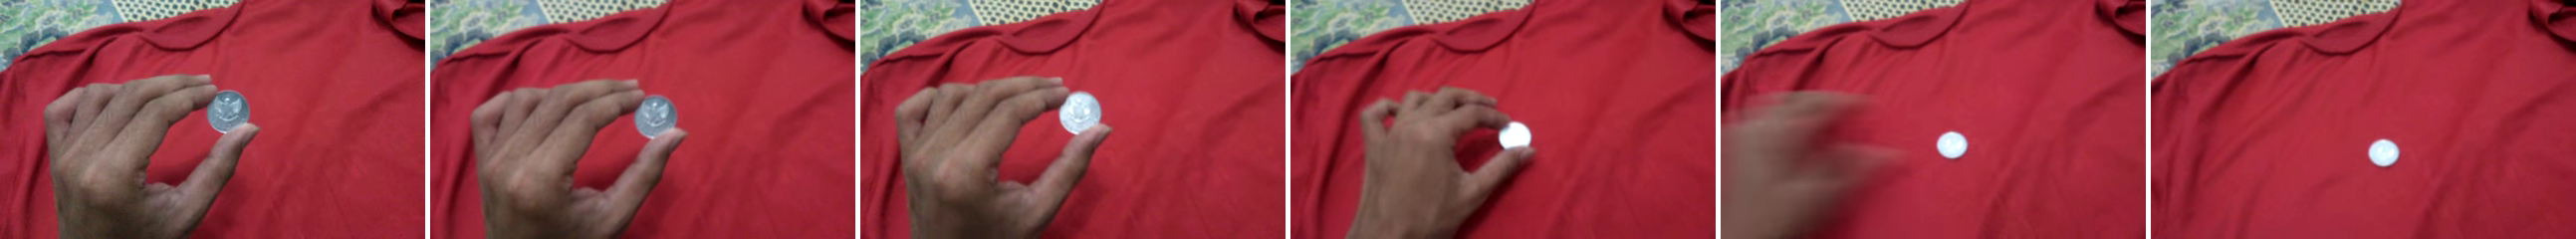

In [66]:
frames = su.video.load_frames_linspace(video_path, n=6)
su.visualize.concat_images_with_border(frames)

In [67]:
x = inputs['pixel_values_videos'].to(device)
thw = inputs['video_grid_thw'].to(device)

In [68]:
with torch.no_grad():
    z = vision_encoder(
        x, thw,
    ).cpu().float()
t, h, w = thw[0].cpu().numpy()
z = einops.rearrange(z, "(t h w) d -> t h w d", t=t, h=h, w=w)
x.shape, z.shape

(torch.Size([12960, 1176]), torch.Size([24, 18, 30, 1280]))

In [69]:
# su.visualize.show_temporal_tsne(z.flatten(0, 2).float(), tsne_kwargs={'method': 'tsne'},)

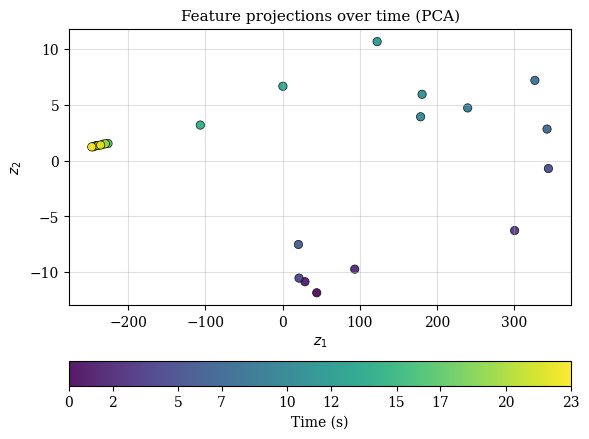

In [70]:
z_t = z.mean(dim=(1, 2))
su.visualize.show_temporal_tsne(z_t.float(), tsne_kwargs={'method': 'pca'},)
# su.visualize.show_temporal_tsne(z_t.float(), tsne_kwargs={'method': 'umap'},)
# su.visualize.show_temporal_tsne(z_t.float(), tsne_kwargs={'method': 'tsne', 'perplexity': 20},)

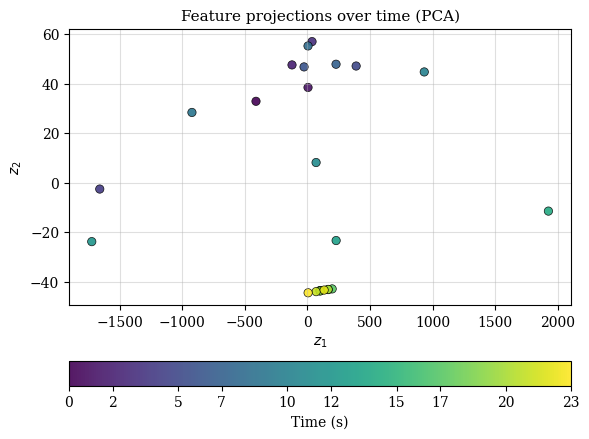

In [76]:
su.visualize.show_temporal_tsne(z[:, 0, 10, :].float(), tsne_kwargs={'method': 'pca'},)

In [86]:
images = [su.visualize.tensor_to_heatmap(x.norm(dim=-1)).resize((frames[0].size)) for x in z]
su.visualize.save_gif(images, "sample.gif", fps=2)